In [12]:
import pathlib
import platform
import warnings
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pymc3 as pm

import arviz as ar
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import cm
import seaborn as sb

In [3]:
ar.style.use('arviz-darkgrid')

In [18]:
warnings.filterwarnings('ignore', category=FutureWarning)

### <u>Package Versions<u>

In [2]:
def pkg_ver(pkgs):
    print('Python & Package Versions')
    print('----------------')
    print(f'PYTHON: {platform.python_version()}')
    for pki in pkgs:
        print(f'{pki.__name__}: {pki.__version__}')
pkg_ver([np, pd, pm, ar, sb])

Python & Package Versions
----------------
PYTHON: 3.7.3
numpy: 1.17.3
pandas: 0.25.0
pymc3: 3.7
arviz: 0.5.1
seaborn: 0.9.0


### <u>Overview</u>

In this and [a subsequent notebook](), I implement bayesian regression models to predict chlorophyll from satellite and ancillary data. Each implementation follows the sequence below.

* The model is cast in a Bayesian framework using a probabilistic programming language (PPL);
* A set of prior predictive simulations is conducted to ascertain that model priors are reasonable;
* The model is fit using the No U-Turn Sampler (NUTS) variant of Hamiltonian Monte Carlo, and the data subset from NOMAD 2008;
* Model predictive skill and  uncertainty are quantified via posterior distribution evaluation and posterior predictive simulation.

In a [third notebook](), the skill of the models are compared using Information Criteria (IC) based methods. These include Watanabe Akaike Information Criterion (WAIC) and/or Pareto Smoothed Importance Sampling Leave-One-Out Cross Validation (LOO).

### <u>The Present Notebook's Linear Models</u>
I include 4 models here:
1. A simple maximum-blue band ratio (*MBR*) regression model.
2. A hierarchical, partially pooled MBR model, where the data is grouped by the blue band of the MBR numerator.
3. A simple linear regression where the inputs are the principal components derived from the PCA of Rrs bands.
4. An OC4-type \\(4^{th}\\)degree polynomial regression.
$$$$

### <u>Loading the Data</u>
The data was stored previously in a [pandas dataframe](https://pandas.pydata.org). 

In [4]:
df = pd.read_pickle('./PickleJar/df_main_2_w_CI.pkl')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 26 columns):
id                4459 non-null int64
etopo2            4459 non-null float64
log_etopo2        4459 non-null float64
lat               4459 non-null float64
rrs411            4293 non-null float64
log_rrs411        4293 non-null float64
rrs443            4456 non-null float64
log_rrs443        4456 non-null float64
rrs489            4422 non-null float64
log_rrs489        4422 non-null float64
rrs510            3435 non-null float64
log_rrs510        3435 non-null float64
rrs555            3255 non-null float64
log_rrs555        3255 non-null float64
rrs670            1598 non-null float64
log_rrs670        1598 non-null float64
CI                1163 non-null float64
CI_OK             4459 non-null int64
MaxBlue           4459 non-null float64
MaxBlueBand       4459 non-null object
MaxBlueBandIdx    4459 non-null int8
mxBlue2Gr         3255 non-null float64
log_mxBlue2Gr     325

Below, I load indices generated from a train/test split procedure, stratified by the blue band used in the numerator of MBR.

In [ ]:
with open('./PickleJar/train_test_indices' ,'rb') as fb:
    tt_pkl_d = pickle.load(fb)
    train_idx_no_nans = tt_pkl_d['train_idx_no_nans']
    test_idx_no_nans = tt_pkl_d['test_idx_no_nans']
    del tt_pkl_d

### <u>Multi-Band Ratio Linear Model</u>
<br>
<a id='MBRlin'/>

A. Pooled Model.

A pooled regression model is simply a regression on a the whole dataset without partitioning the data into distinct groups (see [next section](#MBR-hlin))

In [6]:
df_small = df[['log_mxBlue2Gr', 'MaxBlueBandIdx', 'log_chlor_a']].dropna()

In [7]:
X_ = df_small.log_mxBlue2Gr.values
y = df_small.log_chlor_a.values
X_s = (X_ - X_.mean()) / X_.std()
y_s = (y - y.mean()) / y.std()
X_poly = np.c_[X_s, np.power(X_s, 2), np.power(X_s, 3), np.power(X_s, 4)]

In [14]:
with pm.Model() as mbr_linear_pooled:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    σ = pm.Exponential('σ', 1)
    μ = α + β * X_s
    likelihood = pm.Normal('likelihood', mu=μ, sd=σ, observed=y_s)

In [20]:
mlp_graph = pm.model_to_graphviz(mbr_linear_pooled)
mlp_graph.render(filename='mdl1', directory='./resources', format='png',
                quiet=True)

'./resources/mdl1.png'

<img src='./resources/mdl1.png' />

In [23]:
with mbr_linear_pooled:
    prior_mlp = pm.sample_prior_predictive()
    trace_mlp = pm.sample(2000, tune=1000)
    post_mlp = pm.sample_posterior_predictive(mlp_trace)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]
100%|██████████| 8000/8000 [00:07<00:00, 1042.72it/s]


In [79]:
mlp_struct = ar.from_pymc3(trace=trace_mlp,
                           prior=prior_mlp,
                           posterior_predictive=post_mlp)

mlp_struct.to_netcdf('./ModelResults/mbr_linear_pooled.nc')

In [166]:
def plot_priors(prior_, model_centric=True):
    x_idx = np.argsort(X_s)
    pl.title('Pooled Linear Model Prior Analysis')
    pl.scatter(X_s[x_idx], y_s[x_idx], c=[[1, 0, 0, 0.35]], 
               edgecolor='k', 
               label='true', 
               #alpha=0.65, 
               zorder=3
              )
    if model_centric:
        prior_realizations = prior_['β'][:, None] * X_s + prior_['α'][:, None]
        pl.plot(X_s[x_idx], prior_realizations[0, x_idx].T, color='k',
                alpha=0.1, label='prior model realizations')
        pl.plot(X_s[x_idx], prior_realizations[1:, x_idx].T, color='k',
                alpha=0.1,)
    else:
        mean_prior_y = prior_['likelihood'].mean(axis=0)
        hdi_prior_y = ar.hpd(prior_['likelihood'])
        pl.scatter(X_s[x_idx], mean_prior_y[x_idx], color='k',
               label='prediction mean', zorder=2)
        pl.fill_between(X_s[x_idx], hdi_prior_y[:, 0], hdi_prior_y[:, 1],
                       alpha=0.5, label='model prediction 94%HDI')
    pl.ylabel('log chl (standardized)')
    pl.xlabel('MBR (standardized)')
    pl.legend(loc='upper center');

    
def plot_posteriors(post_, trace_, model_centric=True, num_pred=500):
    x_idx = np.argsort(X_s)
    pl.title('Pooled Linear Model Posterior Analysis')
    pl.scatter(X_s[x_idx], y_s[x_idx], c=[[1, 0, 0, 0.35]], edgecolor='k',
              label='true', alpha=0.65, zorder=3)
    if model_centric:
        realization_idcs = np.random.choice(np.arange(1, 8000, dtype='int'), 
                                            size=500, replace=False)
        post_realizations = trace_['β'][:, None] * X_s + trace_['α'][:, None]
        pl.plot(X_s[x_idx], post_realizations[0, x_idx].T, color='k', 
                alpha=0.1, label='posterior_model realizations')
        pl.plot(X_s[x_idx], 
                post_realizations[realization_idcs[:, None], x_idx[None,:]].T,
               color='k', alpha=0.1)
    else:
        mean_post_y = post_['likelihood'].mean(axis=0)
        hdi_post_y = ar.hpd(post_['likelihood'])
        pl.scatter(X_s[x_idx], mean_post_y[x_idx], color='k',
               label='prediction mean', zorder=2)
        pl.fill_between(X_s[x_idx], hdi_post_y[x_idx, 0], hdi_post_y[x_idx, 1],
                       alpha=0.5, label='model prediction 94%HDI')
    pl.ylabel('log chl (standardized)')
    pl.xlabel('MBR (standardized)')
    pl.legend(loc='lower left');

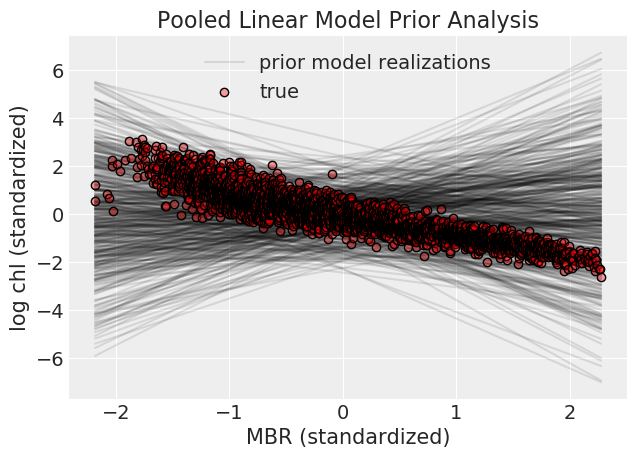

In [124]:
plot_priors(prior_mlp)

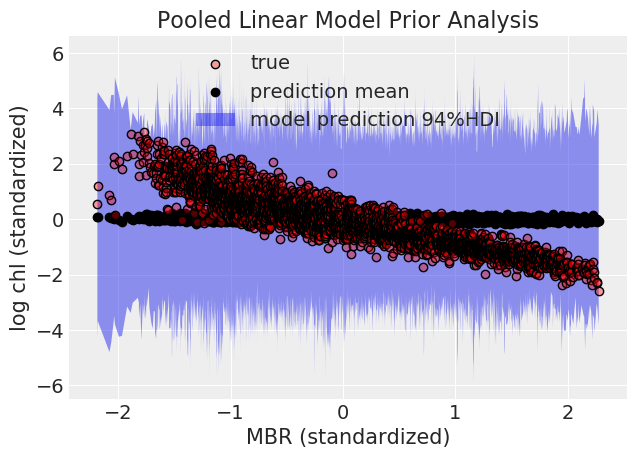

In [165]:
plot_priors(prior_mlp, model_centric=False)

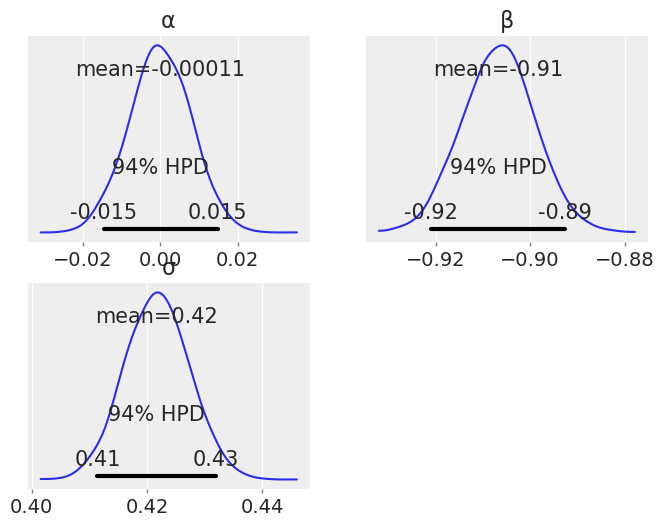

In [89]:
_, ax = pl.subplots(ncols=2, nrows=2, figsize=(8, 6))
ar.plot_posterior(mlp_struct, ax=ax)
ax.ravel()[-1].set_visible(False)

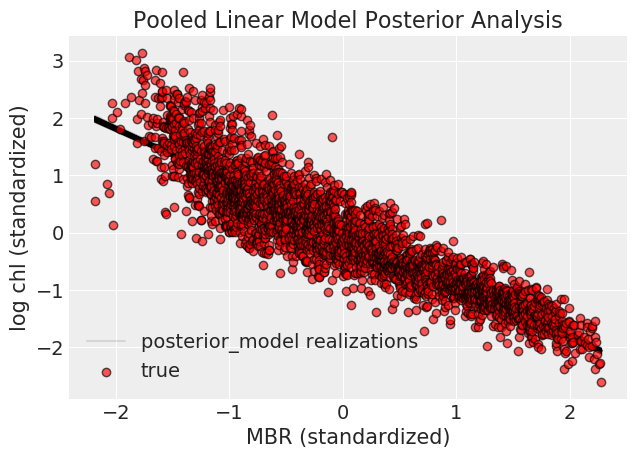

In [160]:
plot_posteriors(post_mlp, trace_mlp)

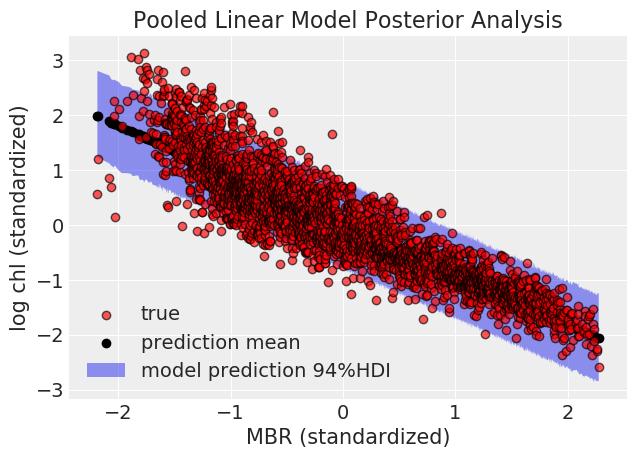

In [167]:
plot_posteriors(post_mlp, trace_mlp, model_centric=False)

<a id='MBR-hlin'/>
B. Hierarchical, Partially Pooled Model<br>

The use of MBR naturally separates the data into 3 groups, based on the blue band used in the numerator of MBR. Thus the model parameters, slope and intercept will be triplicates; slopes and intercepts will each have a common hyperprior. This structure makes the model hierarchical. I will use the MaxBlueBandIdx column, where '0', '1', '2', refer to Rrs443, Rrs490, Rrs510, respectively - column to index into the 3 groups.
As a reminder, the data looks as follows:

In [170]:
df_small.head()

,log_mxBlue2Gr,MaxBlueBandIdx,log_chlor_a
0,-0.267867,2,1.581950
1,-0.220457,2,1.544192
2,-0.268537,2,1.429914
3,-0.279976,2,1.680879
4,-0.167733,2,1.371991


In [8]:
# extracting group index
mbr_idx = df_small.dropna().MaxBlueBandIdx

In [10]:
with pm.Model() as mbr_lin_hier:
    hyper_α_μ = pm.Normal('hyper_α_μ', 0, .1)
    hyper_α_σ = pm.HalfCauchy('hyper_α_σ', 0.1)
    hyper_β_μ = pm.Normal('hyper_β_μ', 0, 0.1)
    hyper_β_σ = pm.HalfCauchy('hyper_β_σ', 0.1)
    β = pm.Normal('β', mu=hyper_β_μ, sd=hyper_β_σ, shape=3)
    α = pm.Normal('α', mu=hyper_α_μ, sd=hyper_α_σ, shape=3)
    μ = α[(mbr_idx,)] + β[(mbr_idx,)] * X_s
    σ = pm.Exponential('σ', 1)
    likelihood = pm.Normal('likelihood', mu=μ, sd=σ, observed=y_s)

/accounts/ekarakoy/anaconda3/envs/bayes_chl/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [181]:
render = pm.model_to_graphviz(mbr_lin_hier)
render.render('mdl2', directory='./resources/', format='png');

<img src='./resources/mdl2.png' />

In [11]:
with mbr_lin_hier:
    prior_mlh = pm.sample_prior_predictive()

/accounts/ekarakoy/anaconda3/envs/bayes_chl/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [213]:
df_small.head()

,log_mxBlue2Gr,MaxBlueBandIdx,log_chlor_a
0,-0.267867,2,1.581950
1,-0.220457,2,1.544192
2,-0.268537,2,1.429914
3,-0.279976,2,1.680879
4,-0.167733,2,1.371991


In [15]:
tab10 = cm.get_cmap('tab10')(np.linspace(0, 1, 10))
tab10[:,-1] = 0.35

c = tab10[mbr_idx]
l = tab10[:3]
c[:, -1] = 0.35
l[:, -1] = 0.05
labels = ['Rrs443', 'Rrs489', 'Rrs510']

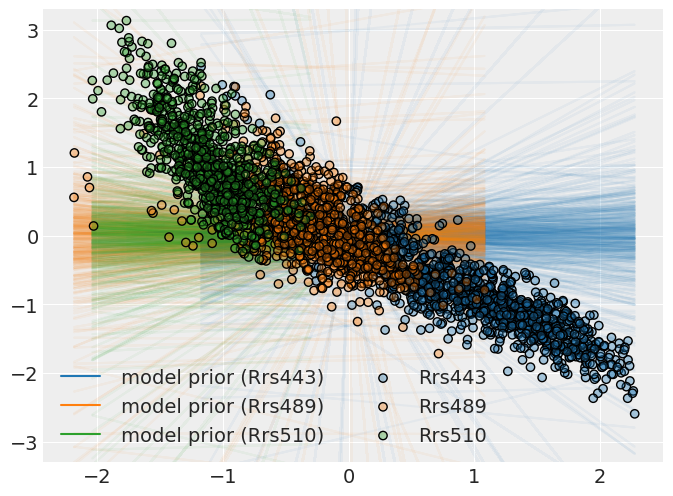

In [16]:
pl.figure(figsize=(8,6))
for i in range(3):
    xi = X_s[mbr_idx==i][None, :]
    yi = y_s[mbr_idx==i]
    ci = c[mbr_idx==i]
    li = l[i]
    ai = prior_mlh['α'][:, i][:, None]
    bi = prior_mlh['β'][:, i][:, None]
    prior_realizations = ai + bi * xi
    pl.scatter(xi, yi, c=ci, edgecolor='k', 
               label=labels[i], zorder=3)
    pl.plot(xi.T, prior_realizations[0], c=l[i], 
            label=f' model prior ({labels[i]})', alpha=0.1)
    pl.plot(xi.T, prior_realizations[10:].T, c=l[i],)
pl.ylim(-3.3, 3.3)
leg = pl.legend(ncol=2, facecolor='white', framealpha=1,
               loc='lower left')
#leg.get_frame().set_facecolor='white'
for l_ in leg.get_lines():
    l_.set_alpha(1)

In [19]:
with mbr_lin_hier:
    trace_mlh = pm.sample(2000, tune=1000)
    post_mlh = pm.sample_posterior_predictive(trace_mlh)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, α, β, hyper_β_σ, hyper_β_μ, hyper_α_σ, hyper_α_μ]
100%|██████████| 8000/8000 [00:06<00:00, 1190.27it/s]


In [21]:
mlh_struct = ar.from_pymc3(trace=trace_mlh,
                           prior=prior_mlh,
                           posterior_predictive=post_mlh)

mlh_struct.to_netcdf('./ModelResults/mbr_linear_hier.nc')

'./ModelResults/mbr_linear_hier.nc'

In [26]:
axs.ravel()[0].get_title()

'α\n0'

In [28]:
np.tile(labels,2)

array(['Rrs443', 'Rrs489', 'Rrs510', 'Rrs443', 'Rrs489', 'Rrs510'],
      dtype='<U6')

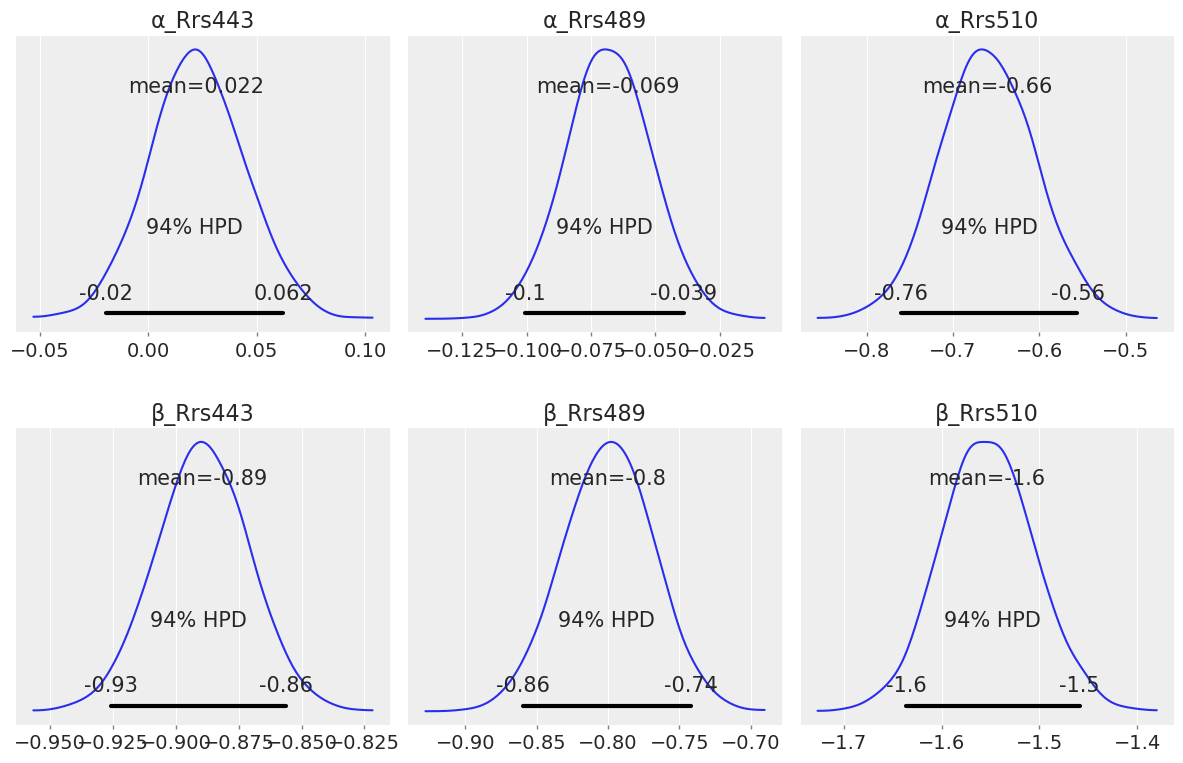

In [31]:
f, axs = pl.subplots(ncols=3, nrows=2,figsize=(12, 8))
ar.plot_posterior(mlh_struct, var_names=['α', 'β'], ax=axs);
f.tight_layout()
for ax, lbl in zip(axs.ravel(), np.tile(labels, 2)):
    ax.set_title(f'{ax.get_title()[0]}_{lbl}')

In [33]:
trace_mlh['α'].shape

(8000, 3)

array([[0.17254902, 0.62745098, 0.17254902, 0.35      ],
       [0.17254902, 0.62745098, 0.17254902, 0.35      ],
       [0.17254902, 0.62745098, 0.17254902, 0.35      ],
       ...,
       [0.17254902, 0.62745098, 0.17254902, 0.35      ],
       [0.17254902, 0.62745098, 0.17254902, 0.35      ],
       [0.17254902, 0.62745098, 0.17254902, 0.35      ]])

In [40]:
ci

array([[0.12156863, 0.46666667, 0.70588235, 0.1       ],
       [0.12156863, 0.46666667, 0.70588235, 0.1       ],
       [0.12156863, 0.46666667, 0.70588235, 0.1       ],
       ...,
       [0.12156863, 0.46666667, 0.70588235, 0.1       ],
       [0.12156863, 0.46666667, 0.70588235, 0.1       ],
       [0.12156863, 0.46666667, 0.70588235, 0.1       ]])

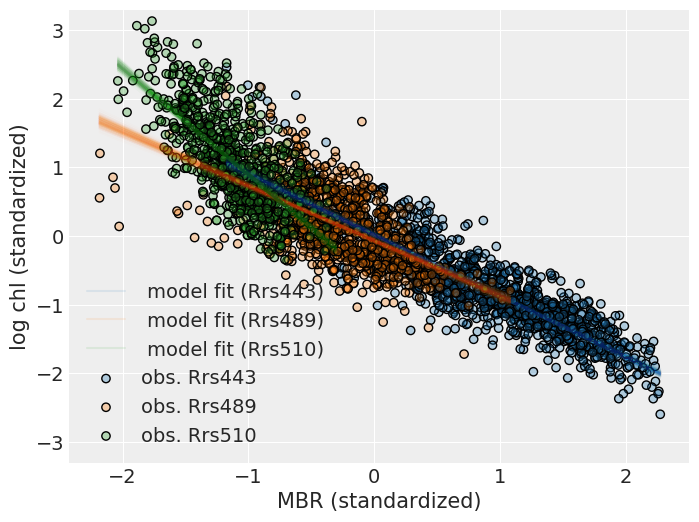

In [43]:
## Plot Posterior Analysis
scatter_alpha = 0.3
line_alpha = 0.01


pl.figure(figsize=(8,6))
for i in range(3):
    xi = X_s[mbr_idx==i][None, :]
    yi = y_s[mbr_idx==i]
    ci = c[mbr_idx==i]
    ci[:, -1] = scatter_alpha
    li = l[i]
    li[-1] = line_alpha
    ai = trace_mlh['α'][:, i][:, None]
    bi = trace_mlh['β'][:, i][:, None]
    post_realizations = ai + bi * xi
    choice_idx = np.random.choice(np.arange(8000, dtype='int'), 200, replace=False)
    pl.scatter(xi, yi, c=ci, edgecolor='k', 
               label=f'obs. {labels[i]}', #zorder=3
              )
    pl.plot(xi.T, post_realizations[0], c=li, 
            label=f' model fit ({labels[i]})', alpha=0.1)
    pl.plot(xi.T, post_realizations[choice_idx].T, c=li,)
pl.ylim(-3.3, 3.3)
leg = pl.legend(ncol=2, facecolor='white', framealpha=1,
               loc='lower left')
for l_ in leg.get_lines():
    l_.set_alpha(1)
pl.ylabel('log chl (standardized)')
pl.xlabel('MBR (standardized)')
pl.legend(loc='lower left');

In [ ]:
def plot_priors_hier(prior_, model_centric=True):
    x_idx = np.argsort(X_s)
    pl.title('Pooled Linear Model Prior Analysis')
    pl.scatter(X_s[x_idx], y_s[x_idx], c=[[1, 0, 0, 0.35]], 
               edgecolor='k', 
               label='true', 
               #alpha=0.65, 
               zorder=3
              )
    if model_centric:
        prior_realizations = prior_['β'][:, None] * X_s + prior_['α'][:, None]
        pl.plot(X_s[x_idx], prior_realizations[0, x_idx].T, color='k',
                alpha=0.1, label='prior model realizations')
        pl.plot(X_s[x_idx], prior_realizations[1:, x_idx].T, color='k',
                alpha=0.1,)
    else:
        mean_prior_y = prior_['likelihood'].mean(axis=0)
        hdi_prior_y = ar.hpd(prior_['likelihood'])
        pl.scatter(X_s[x_idx], mean_prior_y[x_idx], color='k',
               label='prediction mean', zorder=2)
        pl.fill_between(X_s[x_idx], hdi_prior_y[:, 0], hdi_prior_y[:, 1],
                       alpha=0.5, label='model prediction 94%HDI')
    pl.ylabel('log chl (standardized)')
    pl.xlabel('MBR (standardized)')
    pl.legend(loc='upper center');

    
def plot_posteriors(post_, trace_, model_centric=True, num_pred=500):
    x_idx = np.argsort(X_s)
    pl.title('Pooled Linear Model Posterior Analysis')
    pl.scatter(X_s[x_idx], y_s[x_idx], c=[[1, 0, 0, 0.35]], edgecolor='k',
              label='true', alpha=0.65, zorder=3)
    if model_centric:
        realization_idcs = np.random.choice(np.arange(1, 8000, dtype='int'), 
                                            size=500, replace=False)
        post_realizations = trace_['β'][:, None] * X_s + trace_['α'][:, None]
        pl.plot(X_s[x_idx], post_realizations[0, x_idx].T, color='k', 
                alpha=0.1, label='posterior_model realizations')
        pl.plot(X_s[x_idx], 
                post_realizations[realization_idcs[:, None], x_idx[None,:]].T,
               color='k', alpha=0.1)
    else:
        mean_post_y = post_['likelihood'].mean(axis=0)
        hdi_post_y = ar.hpd(post_['likelihood'])
        pl.scatter(X_s[x_idx], mean_post_y[x_idx], color='k',
               label='prediction mean', zorder=2)
        pl.fill_between(X_s[x_idx], hdi_post_y[x_idx, 0], hdi_post_y[x_idx, 1],
                       alpha=0.5, label='model prediction 94%HDI')
    pl.ylabel('log chl (standardized)')
    pl.xlabel('MBR (standardized)')
    pl.legend(loc='lower left');

---
End of this Notebook